In [20]:
import os
import pandas as pd
from ast import literal_eval
from scipy.stats import mannwhitneyu 
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import utils
import numpy as np
from importlib import reload 
from consts import TRNA_DICT, PHS, PCG
# Inverse keys and values in TRNA_DICT


sns.set_context('paper')

pd.set_option('display.max_rows', 500)

plt.style.use('default')

def quick_replace(string):
    try:
        return TRNA_DICT[string]
    except KeyError:
        return None

dtypes = {'RefSeq':'str', 'gene':'str', 'id':'str'}
reload(utils)
PATH = os.getcwd()

# Read in the data
org_df = pd.read_csv(os.path.join(os.path.dirname(PATH), '01_Database_construction', 'DB_csvs', 'final.csv'))
trna_df = pd.read_csv(os.path.join(os.path.dirname(PATH), '01_Database_construction', 'DB_csvs', 'trna_df.csv')).rename({'trna':'gene'}, axis = 1)
rscu_df = pd.read_csv(os.path.join(os.path.dirname(PATH), '01_Database_construction', 'DB_csvs', 'all_rscu_filtered.csv'))
trnascan_df = pd.read_csv(os.path.join(os.path.dirname(PATH), '01_Database_construction', 'DB_csvs', 'trnascan_df.csv'), sep=',', usecols = range(9), skiprows=1).drop(0)

# Set codons to uppercase
trna_df.codon = trna_df.codon.str.upper()
trna_df.anticodon = trna_df.anticodon.str.upper()

# Fix the codon_coubt column so that it only contains the actual number of times the codon appears in PCGs.
rscu_df['codon_count'] = [i[1] for i in rscu_df.codon_count.apply(literal_eval)]

# Remove useless space from the tRNAscan-SE results
trnascan_df.columns = trnascan_df.columns.str.replace(' ', '')

# Split the Name column into the organism's RefSeq ID, gene name, and tRNA ID
trnascan_df[['temp', 'RefSeq', 'gene', 'id']] = trnascan_df['Name'].str.split('_', 3, expand=True)
trnascan_df['RefSeq'] = trnascan_df['temp'] + '_' + trnascan_df['RefSeq']
trnascan_df = trnascan_df.drop(columns = ['temp', 'Name', 'tRNA#', 'Begin', 'End', 'Begin.1', 'End.1'])
trnascan_df.gene = trnascan_df.gene.str.replace(' ', '').apply(quick_replace)
trnascan_df['id'] = trnascan_df['id'].str.replace(' ', '')
trna_df['id'] = trna_df['id'].str.replace(' ', '')

trna_df = trna_df.astype(dtypes).merge(trnascan_df.astype(dtypes), how='left', on=['RefSeq', 'gene', 'id'], indicator=True, sort = True)
trna_df.loc[~trna_df.Codon.isna(), 'anticodon'] = trna_df.loc[~trna_df.Codon.isna(), 'Codon'].str.upper()
trna_df.loc[~trna_df.Codon.isna(), 'codon'] = trna_df.loc[~trna_df.Codon.isna(), 'Codon'].str.upper().apply(utils.reverse_complement)
trna_df.drop(columns = ['Codon', 'Type', 'Score'], inplace = True)

In [21]:
display(rscu_df.head(2))
display(trna_df.head(2))
display(trnascan_df.head(2))


,codon,RSCU_adp,RSCU_raw,codon_count,organism,phylum,class,AA,agreement
0,TTT,1.000000,1.870307,274,Acropora aculeus,Cnidaria,Anthozoa,F,NaN
1,TTC,0.069343,0.129693,19,Acropora aculeus,Cnidaria,Anthozoa,F,NaN


,gene,id,organism,RefSeq,family,order,class,phylum,AA,codon,anticodon,_merge
0,trnA,11370_11429_1,Acanthosaura armata,AB266452,Agamidae,Squamata,Lepidosauria,Chordata,A,GCA,TGC,left_only
1,trnA,11430_11502_1,Acanthosaura armata,AB266452,Agamidae,Squamata,Lepidosauria,Chordata,A,GCA,TGC,left_only


,Type,Codon,Score,RefSeq,gene,id
1,Phe,GAA,97.8,NC_029443.1,trnF,0_69_1
2,Val,TAC,91.7,NC_029443.1,trnV,1022_1094_1


In [22]:
rscu_comb = rscu_df.merge(trna_df[['organism', 'codon', 'anticodon']], how='left', on=['organism', 'codon']).drop(columns = ['agreement'])
display(rscu_comb.tail(5))
rscu_comb.loc[rscu_comb['anticodon'].isnull(), 'anticodon'] = False
rscu_comb.loc[(~rscu_comb['anticodon'].isnull()) & (rscu_comb['anticodon'] != False), 'anticodon'] = True
rscu_comb.rename({'anticodon':'In_mtDNA'}, axis = 1, inplace = True)

# Remove all AA's that dont have atleast one codon in the mtDNA
# Create a mask for the rows that have atleast one codon in the mtDNA and one not in the mtDNA
mask = rscu_comb.groupby(['organism','AA']).agg({'In_mtDNA':'mean'})
mask = mask.loc[(mask['In_mtDNA'] > 0) & (mask['In_mtDNA'] < 1)].reset_index().drop(columns = 'In_mtDNA')

# Combine the mask with the rscu_comb dataframe to keep only the AAs that have atleast one codon in the mtDNA
print(len(rscu_comb.organism.unique()))
rscu_comb = rscu_comb.merge(mask, how='inner', on=['organism', 'AA'])
print(len(rscu_comb.organism.unique()))

rscu_comb.tail()

,codon,RSCU_adp,RSCU_raw,codon_count,organism,phylum,class,AA,anticodon
485562,GAG,0.397059,0.568421,27,Mastigoproctus giganteus,Arthropoda,Arachnida,E,NaN
485563,GGT,0.274336,0.546256,31,Mastigoproctus giganteus,Arthropoda,Arachnida,G,NaN
485564,GGC,0.079646,0.158590,9,Mastigoproctus giganteus,Arthropoda,Arachnida,G,NaN
485565,GGA,1.000000,1.991189,113,Mastigoproctus giganteus,Arthropoda,Arachnida,G,TCC
485566,GGG,0.654867,1.303965,74,Mastigoproctus giganteus,Arthropoda,Arachnida,G,NaN


7892
7632


,codon,RSCU_adp,RSCU_raw,codon_count,organism,phylum,class,AA,In_mtDNA
409553,ATG,0.186869,0.314894,37,Mastigoproctus giganteus,Arthropoda,Arachnida,M,True
409554,GGT,0.274336,0.546256,31,Mastigoproctus giganteus,Arthropoda,Arachnida,G,False
409555,GGC,0.079646,0.158590,9,Mastigoproctus giganteus,Arthropoda,Arachnida,G,False
409556,GGA,1.000000,1.991189,113,Mastigoproctus giganteus,Arthropoda,Arachnida,G,True
409557,GGG,0.654867,1.303965,74,Mastigoproctus giganteus,Arthropoda,Arachnida,G,False


In [23]:
# REPORTS FOR EACH ORGANISM

print(f'N organisms = {len(rscu_comb.organism.unique())}')
print(f'N codons = {len(rscu_comb.codon.unique())}')
print(f'{round(len(trna_df[trna_df.codon == "NONE"])/len(trna_df)*100)}% of codons were not recovered by tRNAscan-SE')

display(rscu_comb.head())


N organisms = 7632
N codons = 63
19% of codons were not recovered by tRNAscan-SE


,codon,RSCU_adp,RSCU_raw,codon_count,organism,phylum,class,AA,In_mtDNA
0,TGA,0.627451,0.771084,32,Acropora aculeus,Cnidaria,Anthozoa,W,True
1,TGG,1.000000,1.228916,51,Acropora aculeus,Cnidaria,Anthozoa,W,False
2,TGA,0.734694,0.847059,36,Acropora aspera,Cnidaria,Anthozoa,W,True
3,TGG,1.000000,1.152941,49,Acropora aspera,Cnidaria,Anthozoa,W,False
4,TGA,0.734694,0.847059,36,Acropora digitifera,Cnidaria,Anthozoa,W,True


c:\Users\noam1\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


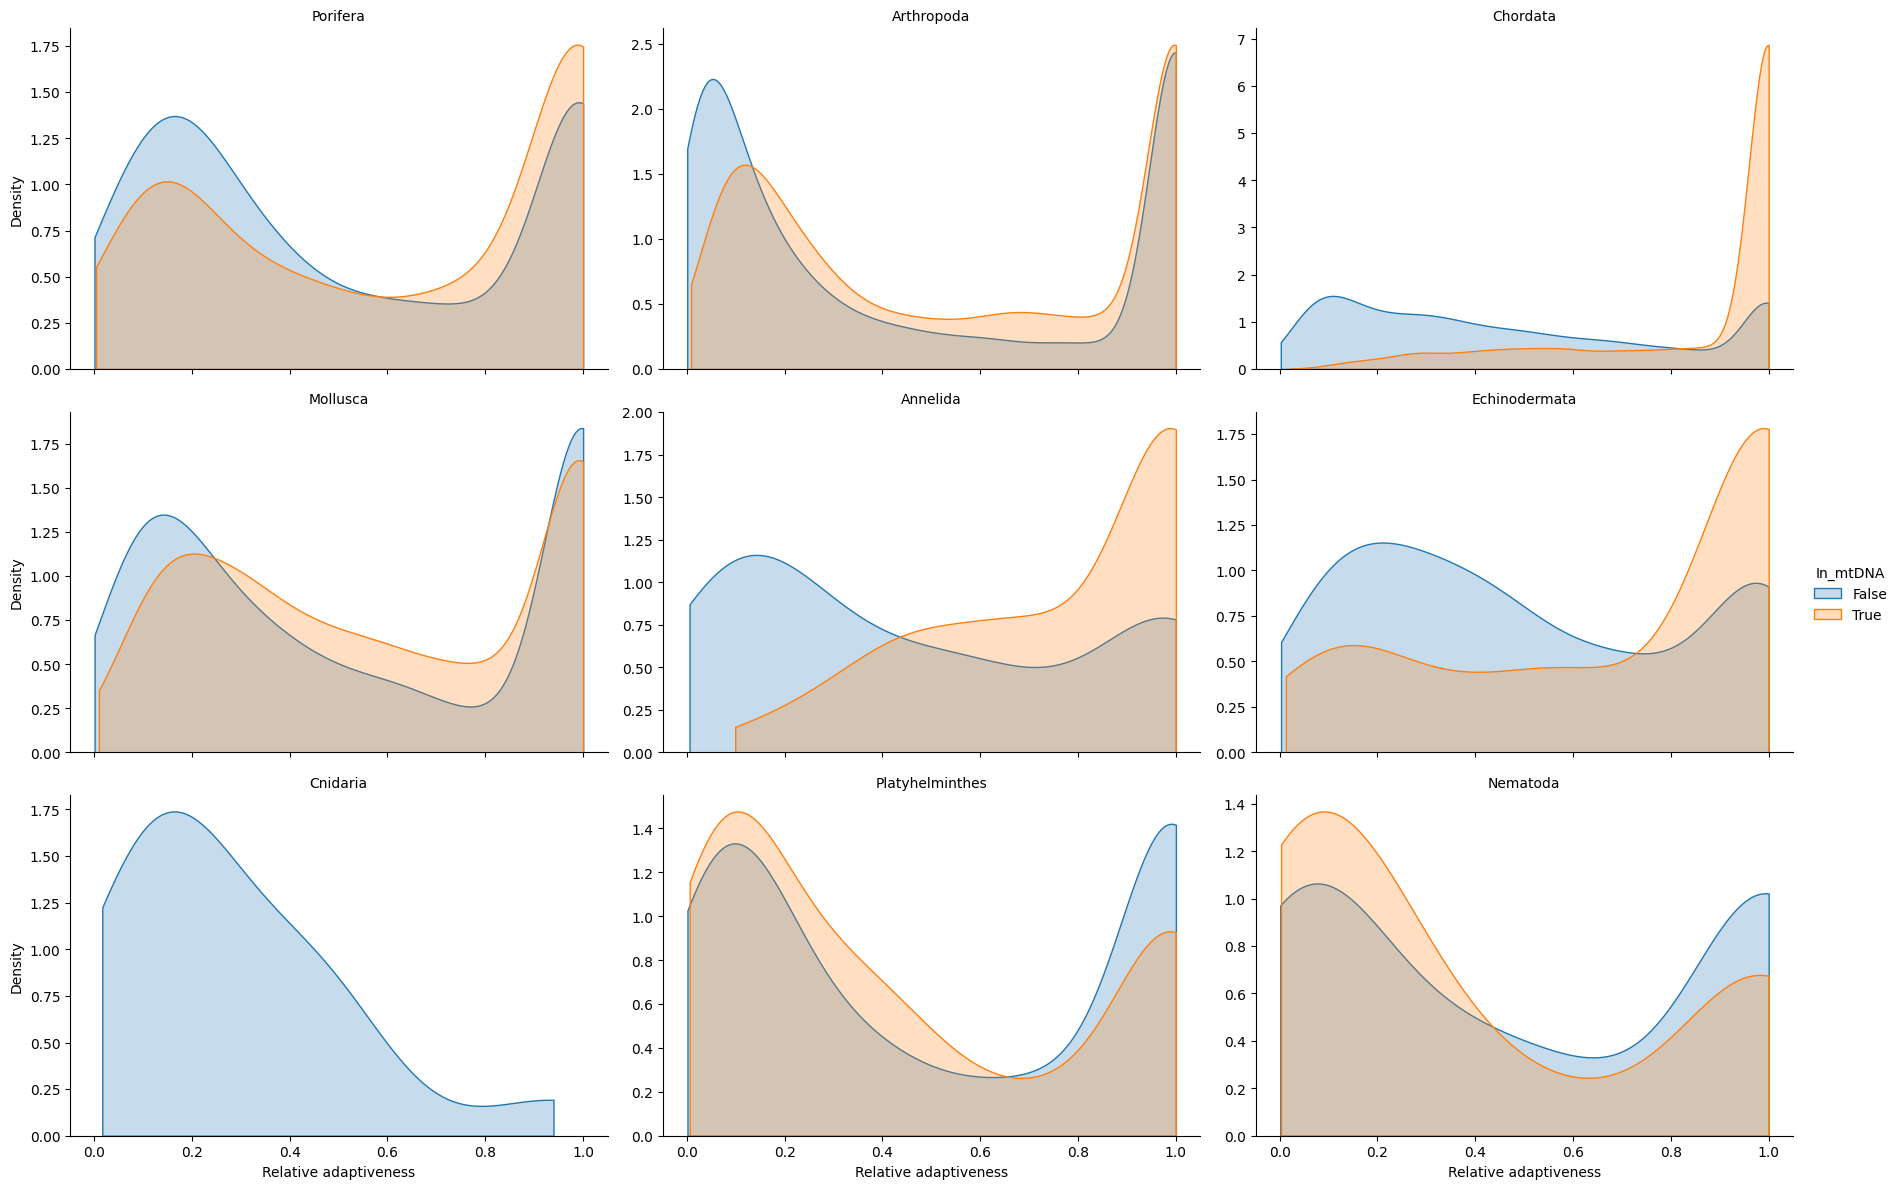

In [8]:
# Create a gridplot of the kde of the RSCU values for each organism (UNUSED IN PAPER)

g = sns.FacetGrid(rscu_comb[rscu_comb.phylum.isin(PHS)], col='phylum', hue = 'In_mtDNA', palette = 'tab10', col_wrap =3, sharex=True, sharey=False, height=4, aspect=1.5)
g.map(sns.kdeplot, 'RSCU_adp', shade=True, palette='tab10', thresh=False, cut=0)
g = g.set_titles("{col_name}")
# Add legend based on the hue_order values
g.add_legend()
g.set_axis_labels('Relative adaptiveness', 'Density')
# Save the fig as pdf in the figures folder

plt.savefig(os.path.join(PATH, 'figures', 'rscu_adp_phylum.pdf'), pad_inches=1.5)

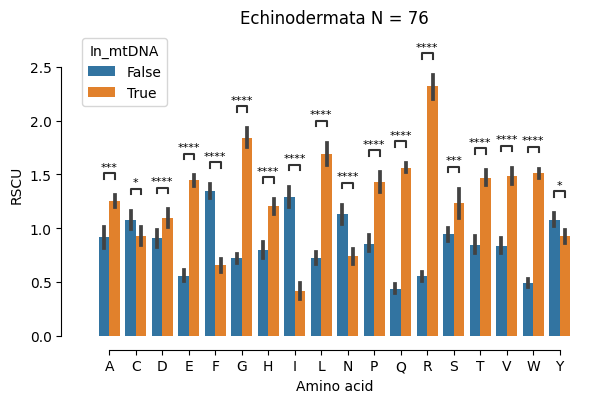

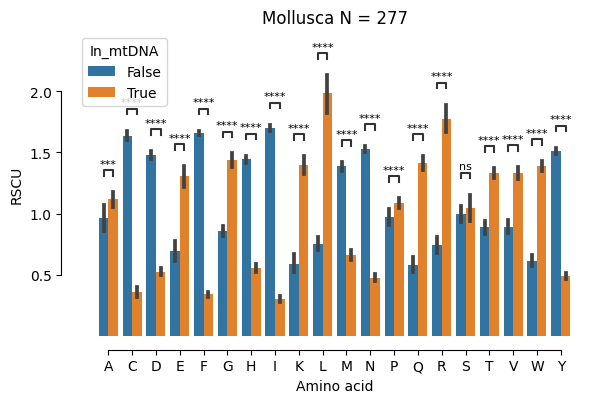

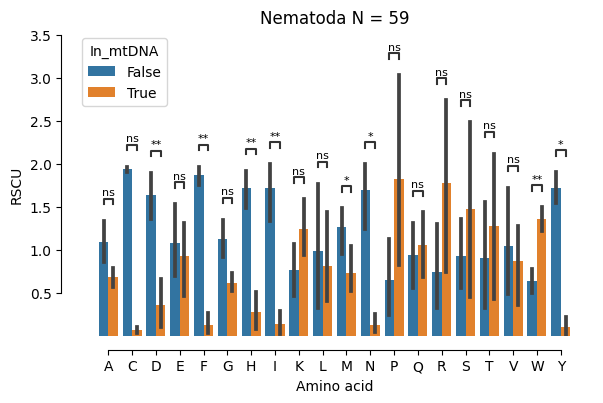

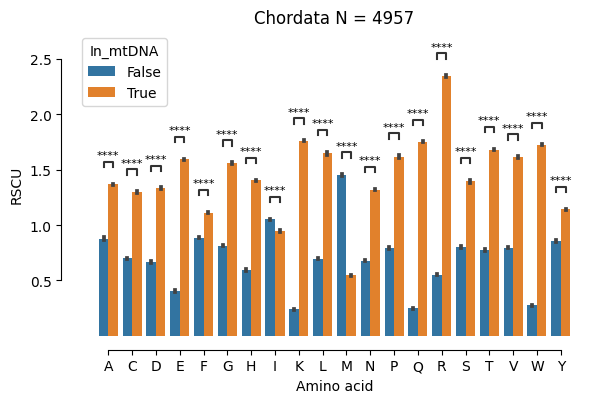

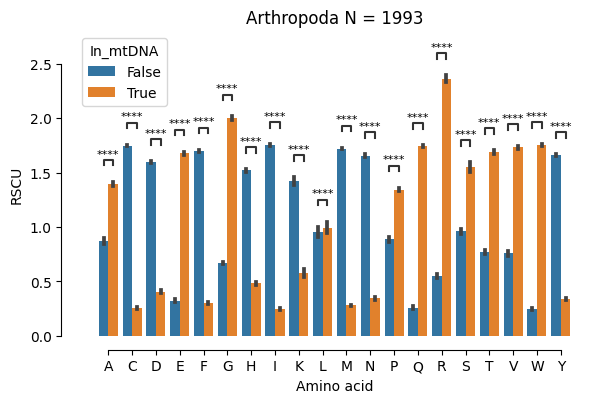

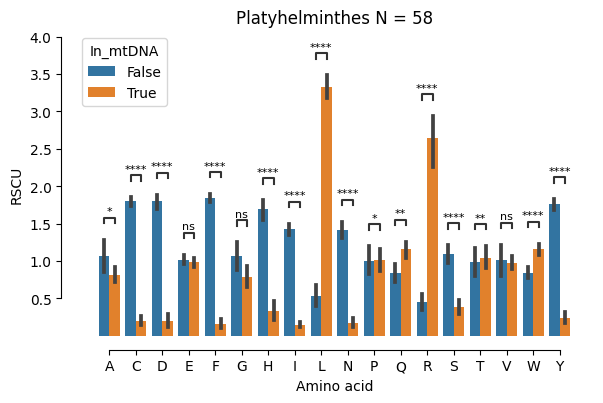

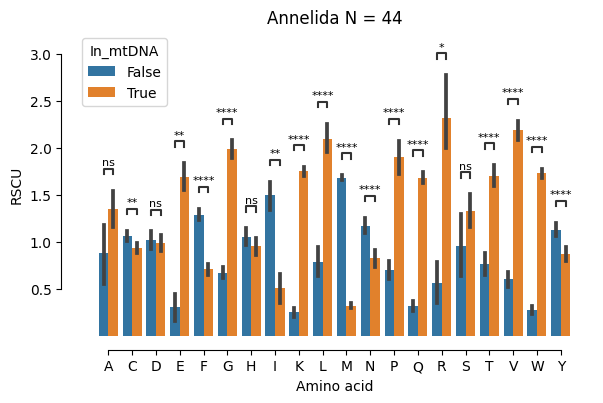

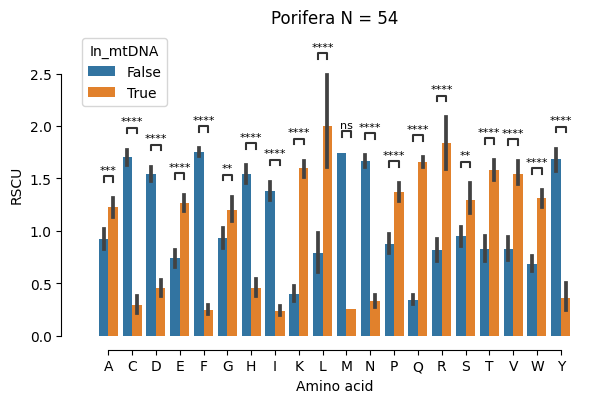

In [24]:
# For each phylum, plot a graph of the raw RSCU values for each amino acid, with stat annotations comparing the values for the mtDNA and non-mtDNA codons
x = "AA"
y = "RSCU_raw"
ph_bias_dict = {i : [] for i in ['phylum', 'mtDNA bias', 'non mtDNA bias', 'Non-significant']}
aa_bias_dict = {i : [] for i in rscu_comb.AA.unique().tolist()}
PHS_nocn = PHS
for ph in PHS_nocn:
    _, ax = plt.subplots(figsize=(6,4))
    data = rscu_comb[rscu_comb.phylum == ph]
    pairs = [[(i, True), (i, False)] for i in data.AA.unique()]
    AAs = sorted(data.AA.unique())
    sns.barplot(ax = ax, x = "AA", y = "RSCU_raw", data = data, hue = 'In_mtDNA', palette = 'tab10', order = AAs)
    ax.set_xlabel('Amino acid')
    ax.set_ylabel('RSCU')
    ax.set_title(f'{ph} N = {len(data.organism.unique())}')
    annotator = Annotator(ax, pairs, data=data, x=x, y=y, order=AAs, hue = 'In_mtDNA', verbose=False)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction = 'benjamini-hochberg', correction_format = 'replace', fontsize = 8)
    annotator.apply_and_annotate() 
    # Move legend
    utils.move_legend(ax, "upper left") 
    plt.tight_layout()

    # Perform a statistical test to calculate the percentage of codons that are biased towards mtDNA, towards not mtDNA and non-significant within each phylum
    
    # Despine the top and right borders
    sns.despine(ax = ax, offset = 10, trim = True)
    
    cur_pvals = multipletests([mannwhitneyu(data[(data.In_mtDNA == True) & (data['AA'] == i)][y], data[(data.In_mtDNA == False) & (data['AA'] == i)][y]).pvalue for i in AAs if\
        len(data[(data.In_mtDNA == True) & (data['AA'] == i)]) > 0 and len(data[(data.In_mtDNA == False) & (data['AA'] == i)]) > 0], method = 'fdr_bh')[1]  # For each amino acid within current phylum, perform a mann-whitney u test and get the pvalue and then perform a FDR correction.
    
    ph_bias_dict['phylum'].append(ph) # Add the phylum to the dictionary
    direction = [(data[(data.In_mtDNA == True) & (data['AA'] == i)][y].mean() - data[(data.In_mtDNA == False) & (data['AA'] == i)][y].mean() > 0) if cur_pvals[ind] < 0.05 else None for ind, i in enumerate(AAs) if\
        (len(data[(data.In_mtDNA == True) & (data['AA'] == i)]) > 0 and len(data[(data.In_mtDNA == False) & (data['AA'] == i)]) > 0)] # For each amino acid within current phylum, calculate the mean of the mtDNA and non-mtDNA codons and compare the means. If the pvalue is less than 0.05, then the means are different and the amino acid is biased towards mtDNA. If the pvalue is greater than 0.05, then the means are the same and the amino acid is not biased towards mtDNA.
    ph_bias_dict['mtDNA bias'].append((direction.count(True)/len(direction)) * 100) # Calculate the percentage of amino acids that are biased towards mtDNA
    ph_bias_dict['non mtDNA bias'].append((direction.count(False)/len(direction)) * 100) # Calculate the percentage of amino acids that are biased towards non-mtDNA
    ph_bias_dict['Non-significant'].append((direction.count(None)/len(direction)) * 100) # Calculate the percentage of amino acids that are not significant

    for i in AAs:
        aa_bias_dict[i].append(True if direction[AAs.index(i)] else False) # Add the direction of bias for each amino acid to the dictionary's corresponding amino acid

    plt.savefig(os.path.join(PATH, 'figures', f'supp_fig_s2_rscu_AA_phylum_{ph}.svg'), pad_inches = .7, dpi = 300)

    

In [25]:
# Measure the percentage of codons that are biased towards mtDNA, towards not mtDNA and non-significant within each phylum
for i in aa_bias_dict:
    aa_bias_dict[i] = np.mean(aa_bias_dict[i], axis = 0)


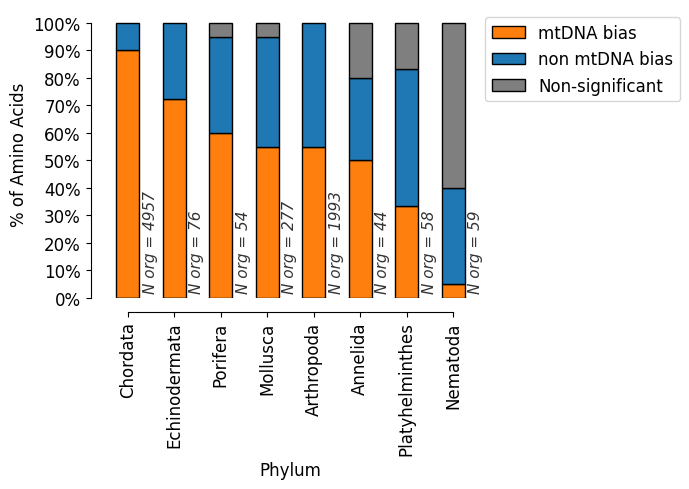

In [26]:
# Create a barplot of the percentage of codons that are biased towards mtDNA, towards not mtDNA and non-significant within each phylum
ph_bias_df = pd.DataFrame.from_dict(ph_bias_dict)
ph_bias_df = ph_bias_df.sort_values(by = 'mtDNA bias', ascending = False)
ph_bias_df.plot(x = 'phylum', kind = 'bar', figsize = (7,5), stacked = True, color = ['tab:orange', 'tab:blue', 'tab:grey'], edgecolor = 'black')
# Chance y axis to percentages
sns.despine(trim = True, offset = 10)
plt.yticks(ticks = list(range(0,101,10)), labels = [f'{i}%' for i in range(0,101,10)], fontsize = 12)
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel('% of Amino Acids', fontsize = 12)
plt.xlabel('Phylum', fontsize = 12)
# Display number of codons in each phylum
for i, v in enumerate(ph_bias_df['phylum']):
    plt.text(i + .32, 2.7, f'N org = {len(rscu_comb[rscu_comb.phylum == v].organism.unique())}', fontsize = 11, rotation = 90, fontstyle = 'oblique', alpha = .8)

# Change legend font size
plt.legend(loc = 'upper left', fontsize = 12, bbox_to_anchor = (1,1))
plt.tight_layout()
plt.savefig(os.path.join(PATH ,'figures', 'fig_1e_rscu_mtDNA_bias.svg'), pad_inches=0.7, dpi = 300)
